here we start our logistic regression project 

Problem Statement: You are given a dataset ("data.h5") containing: - a training set of m_train images labeled as cat (y=1) or non-cat (y=0) - a test set of m_test images labeled as cat or non-cat - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px). You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat. 

loading the dataset. we run a method instead of including a module named load_dataset that is required in the imports in the course module. 

Each line of your train_set_x_orig and test_set_x_orig is an array representing an image 

the following is the image number 7 of the dataset. 

y = [1], it's a 'cat' picture. 

we loaded the following data: 

(209, 64, 64, 3)


Exercise: Find the values for: - m_train (number of training examples) - m_test (number of test examples) - num_px (= height =

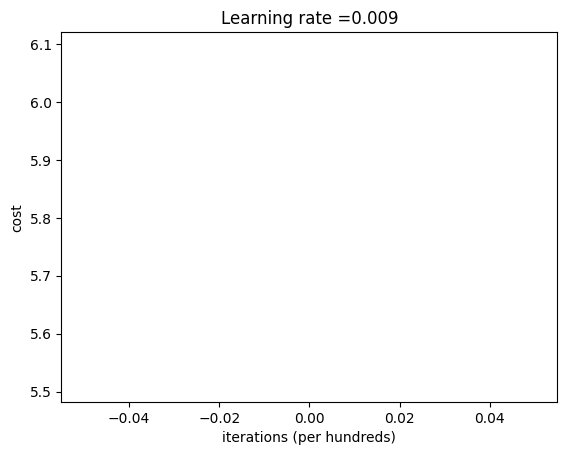

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import scipy.io
from PIL import Image
from scipy import ndimage

print('here we start our logistic regression project \n')
print('Problem Statement: You are given a dataset ("data.h5") containing: - a training set of m_train images labeled as cat (y=1) or non-cat (y=0) - a test set of m_test images labeled as cat or non-cat - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px). You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat. \n')

def load_dataset():
  print('loading the dataset. we run a method instead of including a module named load_dataset that is required in the imports in the course module. \n')
  # file_data = scipy.io.loadmat('dataset.mat')
  train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
  train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
  train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

  test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
  test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
  test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

  classes = np.array(test_dataset["list_classes"][:]) # the list of classes
  
  print('Each line of your train_set_x_orig and test_set_x_orig is an array representing an image \n')

  train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
  test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

  return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

# check an example of a picture that exists in the dataset loaded
print('the following is the image number 7 of the dataset. \n')
index = 7
plt.imshow(train_set_x_orig[index])
plt.close()
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture. \n")

print('we loaded the following data: \n')
print(train_set_x_orig.shape)
print('\n')

# exercise 

print('Exercise: Find the values for: - m_train (number of training examples) - m_test (number of test examples) - num_px (= height = width of a training image) Remember that train_set_x_orig is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access m_train by writing train_set_x_orig.shape[0]. \n') 

m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape) + str('\n'))

# exercise 2

print('Exercise: Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num_px num_px 3, 1). \n')

# A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b*c*d, a) is to use:
# X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
# train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
# test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x_product = train_set_x_orig.shape[1] * train_set_x_orig.shape[2] * train_set_x_orig.shape[3]
test_x_product = test_set_x_orig.shape[1] * test_set_x_orig.shape[2] * test_set_x_orig.shape[3]

train_set_x_flatten = train_set_x_orig.reshape(train_x_product, train_set_x_orig.shape[0] )
test_set_x_flatten = test_set_x_orig.reshape(test_x_product, test_set_x_orig.shape[0])

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ('sanity check after reshaping: ' + str(train_set_x_flatten[0:5,0]) + '\n')

print('To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255. One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel). \n')

# lets standardize the dataset

train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

# **What you need to remember:**
# Common steps for pre-processing a new dataset are:
# Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
# Reshape the datasets such that each example is now a vector of size (num_px * num_px * 3, 1)
# "Standardize" the data

print("let's now determine how to create a neural network that help us solve the problem of identifying cat images\n")
print("the following is a set of steps we will use to solve the problem\n")
print("1. initialize the parameters of the model.\n")
print("2. learn the parameters for the model by minimizing the cost function.\n")
print("3. use the learned parameters to make predictions over the test set.\n")
print("4. analyse the results and conclude.\n")

# building the parts of our algorithm: 
# 1. define the model structure
# 2. initialize the parameters for the model
# 3. loop: calculate current loss (forward propagation), calculate current gradient (backward propagation), update the parameters (gradient descent)
# build each step separately and calculate a method called model where everything is integrated

# exercise 3 
print("implement sigmoid function to make predictions. use np.exp()")

# GRADED FUNCTION: sigmoid 

print("we will start by defining the model structure and the helper methods to execute calculations base in our activation function, and the initialization step which requires an initialize function.\n")
print("1. define the model structure.\n")

def sigmoid(z):
  """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
  sig = 1/(1 + np.exp(-z))
  
  return sig

print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0, 2]))))
print ("\nExercise: Implement parameter initialization in the cell below. You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation.\n")

# GRADED FUNCTION: initialize with zeros

print("2. initialize the model parameter (attributes).\n")

def initialize_with_zeros(dim):
  """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
  
  w = np.zeros((dim, 1))
  b = 0
  
  assert(w.shape == (dim, 1))
  assert(isinstance(b, float) or isinstance(b, int))
  
  return w, b

dim = 2
w, b = initialize_with_zeros(dim)
print("w = " + str(w) + "\n")
print("b = " + str(b) + "\n")

print("3. calculate current loss, current gradient and update the parameters.\n")
print("Exercise: implement a function => propagate() that computes the cost function and its gradients.\n")

# GRADED FUNCTION: propagate

# forward propagation
# - you get X (dataset)
# - you compute the activation function A = sigmoid(wT.X + b) = (a(1), a(2), a(3)...a(m))
# - you calculate the cost function J = -1/m . summation(1 to m) (y(i). log(a(i)) + (1 - y(i). log(1 - a(i))))

# formulas to use:
# dj/dw = 1/m . (X(A - Y)T) => a minus y transpose
# dj/db = 1/m . summation(1 to m) (a(i) -y(i))

def propagate(weights, bias, data, labels):
  """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w(weights) -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b(bias) -- bias, a scalar
    X(data) -- data of size (num_px * num_px * 3, number of examples)
    Y(labels) -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
  data_shape = data.shape[1]
  
  # FORWARD PROPAGATION (FROM data TO cost)
  activations = sigmoid(np.dot(weights.T, data) + bias)
  cost = np.sum((- np.log(activations) * labels + (- np.log(1 - activations)) * (1 - labels)))/ data_shape
  # END FORWARD PROPAGATION  
  
  # BACKWARD PROPAGATION (TO FIND gradients)
  dw = (np.dot(data, (activations-labels).T))/data_shape
  db = (np.sum(activations-labels))/data_shape
  # END BACKWARD PROPAGATIONS
  
  assert(dw.shape == weights.shape)
  assert(db.dtype == float)
  cost = np.squeeze(cost)
  assert(cost.shape == ())
  
  gradients = {"dw": dw, 
               "db": db}
  
  return gradients, cost

weights, bias, data, labels = (np.array([[1.], [2.]]), 
                               2., 
                               np.array([[1., 2., -1.],[3., 4., -3.2]]), 
                               np.array([[1, 0, 1]]))
grads, cost = propagate(weights, bias, data, labels)
print ("calculate the propagation function with weights = 1. and 2. , bias = 2. , data = [1.,2.,-1.],[3.,4.,-3.2] and  labels = [1, 0, 1]. \n")
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

# optimization

print("Exercise: Implement the optimization function in the cell below.\n")
print("Write down the optimization function. The goal is to learn weights and bias by minimizing the cost function J. For a parameter theta, the update rule is theta = theta - activation * dtheta, where activation is the learning rate.\n")

def optimize(weights, bias, data, labels, num_iterations, learning_rate, print_cost = False):
  """
    This function optimizes weights and bias by running a gradient descent algorithm
    
    Arguments:
    weights -- a numpy array of size (num_px * num_px * 3, 1)
    bias -- a scalar
    data -- data of shape (num_px * num_px * 3, number of examples)
    labels -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
  
  costs = []
  
  for iteration in range(num_iterations):
    # Cost and gradient calculation (≈ 1-4 lines of code)
    ## START CODE HERE ##
    grads, cost = propagate(weights, bias, data, labels)
    ## END CODE HERE ##
    
    # Retrieve derivatives from grads
    dw = grads["dw"]
    db = grads["db"]
    
    # update rule (≈ 2 lines of code)
    ## START CODE HERE ##
    weights = weights - learning_rate * dw
    bias = bias - learning_rate * db
    ## END CODE HERE ##
    
    if iteration % 100 == 0:
      costs.append(cost)
    
    # Record the costs
    if print_cost and iteration % 100 == 0:
      costs.append(cost)
      print("Cost after iteration %i: %f" %(iteration, cost))
          
          
  params = {
    "weights": weights,
    "bias": bias
  }
  
  grads = {
    "dw": dw,
    "db": db
  }
  
  return params, grads, costs

# evaluate the optimization of the model and plot the costs obtained from the evaluation of the cost function

params, grads, costs = optimize(weights, bias, data, labels, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("weights = " + str(params["weights"]))
print ("bias = " + str(params["bias"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

# plot the costs
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(0.009))
plt.show()

